<h2>Project 7: CART</h2>


<!--announcements-->
<blockquote>
    <center>
    <img src="forest.jpg" width="400px" />
    </center>
      <p><cite><center>Boosting took a long time to be truly understood.<br>
      ... cynics say we didn't see the forest for all the trees ...<br>
      </center></cite></p>
</blockquote>

<!--announcements-->






<h3>Introduction</h3>
<p>In this assignment you will implement a decision tree algorithm and then use it for bagging and boosting. We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value). Nodes have six fields: 

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> so long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>
</ol>
</p>


        

In [1]:
#<GRADED>
class TreeNode(object):
    """Tree class.
    
    (You don't need to add any methods or fields here but feel
    free to if you like. Our tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction
#</GRADED>

<h3>Implementing CART</h3>
Before we get started let us add a few packages that you might need. We will also load a data set <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
%matplotlib inline

#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
#</GRADED>
import matplotlib.pyplot as plt
from scipy.io import loadmat

# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTr  = data['xTr'].T
yTr  = data['yTr'].flatten()
xTe  = data['xTe'].T
yTe  = data['yTe'].flatten()

# cut off the first two dimensions for visualization
xTr2d = xTr[:, 0:2]
xTe2d = xTe[:, 0:2]

xTr.shape, yTr.shape, xTe.shape, yTe.shape

((281, 34), (281,), (70, 34), (70,))

<h3> Efficiently implementing regression trees </h3>
<p>First, implement the function <code>sqsplit</code> which takes as input a (weighted) data set with labels and computes the best feature and cut-value of an optimal split based on minimum squared error. The third input is a weight vector which assigns a positive weight to each training sample. The loss you should minimize is the averaged weighted squared-loss:
$$
	{\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2.\label{q2:loss}
$$
<br>
</p>

You are building a regression tree, and right now you need to choose a split for the given dataset $S=\{(\vec x_1,y_1),\dots,(\vec x_n,y_n)\}$ (where we have continuous labels $y_i\in{\cal R}$).
Suppose you split on some feature $j$ with value $c$ and partition the dataset in to two sets of indices, $L$--the set of indices on the left (i.e., $i \in L \Rightarrow [x_{i}]_{j} < c$)--and $R$--the set of indices on the right (i.e., $i \in R \Rightarrow [x_{i}]_{j} > c$). Suppose you assign every data point on the left the prediction $T_{L}$ and every data point on the right the prediction $T_{R}$. Finally, suppose that each data point $x_{i}$ has an associated weight $w_{i}$, and that the weights are normalized (i.e., $\sum_{i} w_{i} = 1$). 


<p> First, we show that setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets (i.e., $T_{L} = \frac{1}{W_{L}}\sum_{i\in L}w_{i}y_{i}$ and $T_{R} = \frac{1}{W_{R}}\sum_{i\in R}w_{i}y_{i}$) minimizes the loss $\cal L$, where $W_{L}=\sum_{i \in L}w_{i}$ and $W_{R}=\sum_{i \in R} w_{i}$ are the total weight of the left and right side respectively.

<p> We take the derivative of the loss with respect to $T_{L}$ to obtain $$\frac{d}{dT_{L}} {\cal L}(S) = -2\sum_{i \in L}w_{i}(y_i - T_L)=-2\sum_{i\in L}w_iy_i + 2T_{L}\sum_{i}w_{i}$$ Setting this equal to zero and solving, we get $$2T_{L}w_{L}=2\sum_{i \in L}w_{i}y_{i}$$ and therefore $$T_{L} = \frac{1}{W_{L}}\sum_{i \in L}w_{i}y_{i}$$ A symmetric argument holds for $T_{R}$.</p>

<p> Now, imagine you are considering splitting on some feature $j$, and suppose you have already sorted the training points in the order of this feature value, so that $[x_{1}]_{j} < [x_{2}]_{j} < \cdots < [x_{n}]_{j}$. You'd like to choose a split from among $c_{1} \leq c_{2} \leq \cdots \leq c_{n-1}$, where $c_{i}=\frac{[x_{i}]_{j}+[x_{i+1}]_{j}}{2}$. One way to do this would be to, for each possible split $c_{k}$, decide whether each $x_{i}$ should be partitioned left or right, and compute $\cal L$. At the end, take the split with the lowest loss. The number of data points $n$ and there are $O(n)$ splits to consider, and the proposed algorithm would require $O(n)$ per split to evaluate $\cal L$, for a total of $O(n^2)$ time.

<p> Now, suppose some split $c_{k}$ results in the data being partitioned in to $L^{(k)}$ and $R^{(k)}$. Suppose you are given the following quantities precomputed: $W_{L^{(k)}}$, $P_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}$, and $Q_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}^{2}$. Similarly, you are given $W_{R^{(k)}}$, $P_{R^{(k)}}$ and $Q_{R^{(k)}}$ Equipped with these precomputed quantities, we can compute $\cal L$ in constant time:

<p>Expand the left side of the loss to $$\sum_{i \in L}w_{i}y_{i}^{2} - 2\sum_{i \in L}w_{i}y_{i}T_{L} + \sum_{i \in L}w_{i}T_{L}^{2}$$. The first term is exactly $Q_{L^{(k)}}$. The second term can be written as $-2P_{L^{(k)}}\frac{P_{L^{(k)}}}{W_{L^{(k)}}}=-2\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The last term can be written as $w_{L^{(k)}}\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}^{2}}=\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The second term plus the third term is therefore simply $-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. Therefore the whole expression can be evaluated as: $$Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$$ Similarly, the right term is: $$Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$</p>

<p> <b> Efficent Update Rule: </b> If all feature values are distinct, only one data point moves from $R$ to $L$ when moving from split $k$ to split $k+1$. Therefore, we simply update the values accordingly. For example, we subtract $w_{k}$ from $W_{R^{(k)}}$ and add it to $W_{L^{(k)}}$. We subtract $w_{k}y_{k}$ from $P_{R^{(k)}}$ and add it to $P_{L^{(k)}}$. We subtract $w_{k}y_{k}^{2}$ from $Q_{R^{(k)}}$ and add it to $Q_{L^{(k)}}$. Crucially, all of these updates take only constant time. </p>

In [4]:
#<GRADED>
def sqsplit(xTr,yTr,weights=[]):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights == []: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    # TODO:
    #raise Exception("Not Implemented")

    for j in range(D):
        q_l, q_r = 0, weights.dot(np.power(yTr, 2))
        p_l, p_r = 0, weights.dot(yTr)
        w_l, w_r = 0, 1
        index = np.argsort(xTr[:,j])
        
        for i in range(N - 1):
            q_l += weights[index[i]]*yTr[index[i]]*yTr[index[i]]
            q_r -= weights[index[i]]*yTr[index[i]]*yTr[index[i]]
        
            p_l += weights[index[i]]*yTr[index[i]]
            p_r -= weights[index[i]]*yTr[index[i]]
        
            w_l += weights[index[i]]
            w_r -= weights[index[i]]
            temp_loss = q_l - p_l**2/w_l + q_r - p_r**2/w_r
            if xTr[index[i], j] == xTr[index[i + 1], j]:
                continue
            if temp_loss < bestloss:
                bestloss = temp_loss
                feature = j
                cut = xTr[index[i], j]
    
    
    
    return feature, cut, bestloss    
    return feature, cut, bestloss
    

#</GRADED>

In [5]:
t0 = time.time()
fid,cut,loss = sqsplit(xTr,yTr)
t1 = time.time()
print('elapsed time:',t1-t0,'seconds')
print("It should split on feature 2 on value 0.29920161791103117")
print("Split on feature",fid,"on value:",cut)

elapsed time: 0.04296374320983887 seconds
It should split on feature 2 on value 0.29920161791103117
Split on feature 2 on value: 0.29920161791103117


<b>Cart tree:</b><p>Implement the function <code>cart</code> which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, test data, a maximum depth, and the weigh of each training example. Maximum depth and weight are optional arguments. If they are not provided you should make maximum depth infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>


In [6]:
#<GRADED>
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    # TODO:
    prediction = np.dot(w, yTr)
    tree = TreeNode(None, None, None, None, None, prediction)
    if depth == 1 or np.all(yTr==yTr[0]) or yTr.shape[0] < 2: 
        return tree
    fid,cut,_ = sqsplit(xTr,yTr)

    tree = TreeNode(None, None, None, fid, cut, prediction)
  
    yTr =  yTr.reshape(yTr.shape[0], 1)    
    w = w.reshape(w.shape[0], 1)
    
    xTr_y_w = np.concatenate([xTr, yTr, w], axis=1)
    temp = xTr[:, fid]
    xL_y_w = xTr_y_w[xTr_y_w[:,fid]<=cut]
    xR_y_w = xTr_y_w[xTr_y_w[:,fid]>cut]
    
    yL = xL_y_w[:,d]
    yR = xR_y_w[:,d]
    
    xL = xL_y_w[:,0:d]
    xR = xR_y_w[:,0:d]
    
    wL = xL_y_w[:, d+1]
    wR = xR_y_w[:, d+1]
    
    tree.left = cart(xL, yL, depth - 1, wL/sum(wL))
    tree.right = cart(xR, yR, depth - 1, wR/sum(wR))
    
    tree.left.parent = tree
    tree.right.parent = tree
    
    return tree    
    #raise Exception("Not Implemented")
    
#</GRADED>

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [7]:
#<GRADED>
def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    assert root is not None
    #n = xTe.shape[0]
    #pred = np.zeros(n)
    
    pred = []
    n, _ = xTe.shape
    # TODO:
    pred = list(pred)
    for i in range(n):
        tree = root
        while (tree.left != None):
            fid = tree.cutoff_id
            val = tree.cutoff_val
            if (xTe[i, fid] <= val).all():
                tree = tree.left
            else:
                tree = tree.right
        pred.append(tree.prediction)
    pred = np.asarray(pred)
    
    return pred
    raise Exception("Not Implemented")

    return pred
#</GRADED>

In [8]:
t0 = time.time()
root = cart(xTr, yTr)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTr) - yTr)**2)
te_err   = np.mean((evaltree(root,xTe) - yTe)**2)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f" % te_err)

elapsed time: 0.21 seconds
Training RMSE : 0.00
Testing  RMSE : 0.57


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


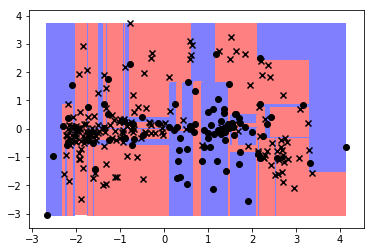

Training error: 0.0000
Testing error:  0.2286


In [9]:
def visclassifier(fun,xTr,yTr,w=[],b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(yTr)

    plt.figure()

    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    testpreds = fun(xTe)
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )

    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    plt.show()
    
tree=cart(xTr2d,yTr) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X),xTr2d,yTr)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTr2d)) != yTr))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTe2d)) != yTe))

<h2>Random Forests</h2>
<p>CART trees are known to be high variance classifiers
(if trained to full depth).
An effective way to prevent overfitting is to use <b>Bagging</b>.
Implement the function <code>forest</code>,
which builds a forest of regression trees.
Each tree should be built using training data
drawn by randomly sampling $n$ examples
from the training data with replacement.
Do not randomly sample features.
The function should output a list of trees.</p>

In [11]:
#<GRADED>
def forest(xTr, yTr, m, maxdepth=np.inf):
    """Creates a random forest.
    
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        
    Output:
        trees: list of TreeNode decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    # TODO:
    for i in range(m):
        index = np.random.randint(0, n, n)
        sub_x = xTr[index, :]
        sub_y = yTr[index]
        tree = cart(sub_x, sub_y, maxdepth)
        trees.append(tree)   
    return trees

    #raise Exception("Not Implemented")
#</GRADED>

<p>Now implement the function <code>evalforest</code>, which should take as input a set of $m$ trees, a set of $n$ test inputs, and an $m$ dimensional weight vector. Each tree should be weighted by the corresponding weight. (For random forests you can define the weights to be $\frac{1}{m}$ for all trees.</p>

In [12]:
#<GRADED>
def evalforest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)
    
    # TODO:
    for j in range(m):
        temp = evaltree(trees[j], X)
        pred += temp * alphas[j]
    
    return pred
    #raise Exception("Not Implemented")  

#</GRADED>

<p>The following script visualizes the decision boundary of a random forest ensemble.</p>

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


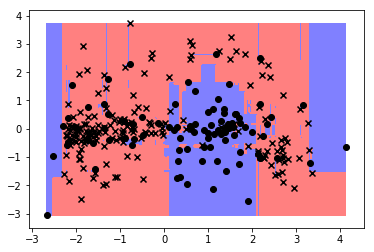

Training error: 0.0000
Testing error:  0.1143


In [ ]:
trees=forest(xTr2d,yTr,100) # compute tree on training data 
visclassifier(lambda X:evalforest(trees,X),xTr2d,yTr)

print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTr2d)) != yTr))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTe2d)) != yTe))

<p>The following script evaluates the test and training error of a random forest ensemble as we vary the number of trees.</p>

In [ ]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
for i in range(M):
    trees=forest(xTr,yTr,i+1)
    trErr = np.mean(np.sign(evalforest(trees,xTr)) != yTr)
    teErr = np.mean(np.sign(evalforest(trees,xTe)) != yTe)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

[0]training err = 0.0391	testing err = 0.1429
[1]training err = 0.1281	testing err = 0.1714
[2]training err = 0.0214	testing err = 0.1286
[3]training err = 0.0214	testing err = 0.1714
[4]training err = 0.0036	testing err = 0.0714
[5]training err = 0.0178	testing err = 0.1857
[6]training err = 0.0000	testing err = 0.1000
[7]training err = 0.0142	testing err = 0.1571
[8]training err = 0.0000	testing err = 0.1000
[9]training err = 0.0071	testing err = 0.0857
[10]training err = 0.0071	testing err = 0.1143
[11]training err = 0.0036	testing err = 0.1000
[12]training err = 0.0036	testing err = 0.0857
[13]training err = 0.0000	testing err = 0.1286
[14]training err = 0.0000	testing err = 0.0714
[15]training err = 0.0000	testing err = 0.0571


<h2>Boosting</h2>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. Implement the function <code>boosttree</code>, which applies Adaboost on your <code>cart</code> functions. You should be able to use the function <code>evalforest</code> to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [ ]:
#<GRADED>
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    # TODO:

    count = 0
    eps = 0
    while eps < 0.5 and count < maxiter:
        tree = cart(x, y, maxdepth, weights)
        forest.append(tree)
        
        pred = evaltree(tree, x)
        
        temp = np.multiply(pred, np.asarray(y))
        temp_lis = temp.tolist()
        index = [0 if item > 0 else 1 for item in temp_lis ]
        eps = (np.asarray(index)).dot(weights)
        alpha = 0.5 * np.log((1 - eps) / eps)
        alphas.append(alpha)
        
        new = np.exp(-alpha * (np.multiply(pred, y)))
        new = np.multiply(new, weights)
        weights = 0.5 / np.sqrt(eps * (1 - eps)) * new
        count += 1
    
    return forest, alphas

    #raise Exception("Not Implemented") 
#</GRADED>

<p>The following script evaluates the test and training error of a boosted forest as we increase the number of trees.</p>

In [ ]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
for i in range(M):
    forest,alphas=boosttree(xTr,yTr,maxdepth=3,maxiter=i+1)
    trErr = np.mean(np.sign(evalforest(forest,xTr,alphas)) != yTr)
    teErr = np.mean(np.sign(evalforest(forest,xTe,alphas)) != yTe)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()